# Exploring methods for improving the production model.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

import plotly.express as px

In [2]:
__context__ = 'local'

import sys

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    libraryLocation = '..'
    from public_timeseries_testing_util import MockApi
    env = MockApi()
    

elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    libraryLocation = '/kaggle/input/'
    import enefit
    env = enefit.make_env()

iter_test = env.iter_test()
sys.path.append(libraryLocation)

## Training on nonzero prediction data:

The results and discussion in notebook 1.3.0 suggest that training on only daylight data might be a good way to improve the linear regression fits to a tolerable level.

In [3]:
from enefittools.data import format_dfs

train = pd.read_csv(trainDataLocation+'train.csv')
client = pd.read_csv(trainDataLocation+'client.csv')

weather_forecast = pd.read_csv(trainDataLocation+'forecast_weather.csv')
weather_historical = pd.read_csv(trainDataLocation+'historical_weather.csv')

solar = pd.read_csv(libraryLocation + '/enefittools/data/datasets/solar_data.csv')

train, client, weather_historical, weather_forecast, solar = \
                format_dfs(target=train, client=client, weather_historical=weather_historical,
                           weather_forecast=weather_forecast, solar=solar)


In [4]:
train = train.filter( pl.col('is_consumption') == False)

In [5]:
solarXtrain = train.join(solar, left_on='prediction_datetime', right_on='datetime', how='left')

In [6]:
from enefittools.features.regression_features import make_date_process, make_regression_features
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from enefittools.models import make_wrapped_model

dates = make_date_process(train)

unfiltered_features = make_regression_features(solarXtrain, client, dates)
filtered_features = make_regression_features(solarXtrain.filter( pl.col('solar_elevation')>0),
                                             client, dates)

model_filter = make_wrapped_model( TransformedTargetRegressor, regressor=LinearRegression(), 
                        func=np.log1p, inverse_func=np.expm1)

model_unfilter = make_wrapped_model( TransformedTargetRegressor, regressor=LinearRegression(), 
                        func=np.log1p, inverse_func=np.expm1)

In [7]:
model_filter.fit(filtered_features, train)

WrappedModel()

In [8]:
model_unfilter.fit(unfiltered_features, train)

WrappedModel()

In [9]:
def make_error(predictions):
    return predictions.join(train[['row_id', 'target', 'prediction_datetime']],
                                  on='row_id', suffix='_true'
                           ).with_columns(
                                pl.col('target').alias('prediction'),
                                ((pl.col('target_true') - pl.col('target'))).alias('error') 
                           )


errors_filtered = make_error( model_filter.predict(filtered_features) )
                            
errors_unfiltered = make_error( model_unfilter.predict(unfiltered_features) )


In [10]:
print('pre-filtered', (errors_filtered['error']**2).mean()**0.5) 
print('not filtered', (errors_unfiltered['error']**2).mean()**0.5) 

pre-filtered 358.6084480890325
not filtered 354.55141093695886


Nope. It's actually worse to filter. Could this be because we are averaging in the low error night-time predictions?

In [11]:
# average in the missing datapoints
filtered_w_zeros = unfiltered_features[['row_id', 'prediction_unit_id']].join(
                                model_filter.predict(filtered_features), on='row_id', how='left'
                        ).fill_null(strategy="zero")

error_w_zeros = make_error(filtered_w_zeros)

In [12]:
print('pre-filtered with zeros at night', (error_w_zeros['error']**2).mean()**0.5) 

pre-filtered with zeros at night 249.28840304700884


Yes. Here we make predictions of 0 at night-time (as defined by solar_elevation), and average that in. This shows that, yes, we've improved the performance.

To me, this looks like we effectively reallocated the power of our model toward the predicting the daytime fluctuations, where the linear error is most improved by improvements in the log model.

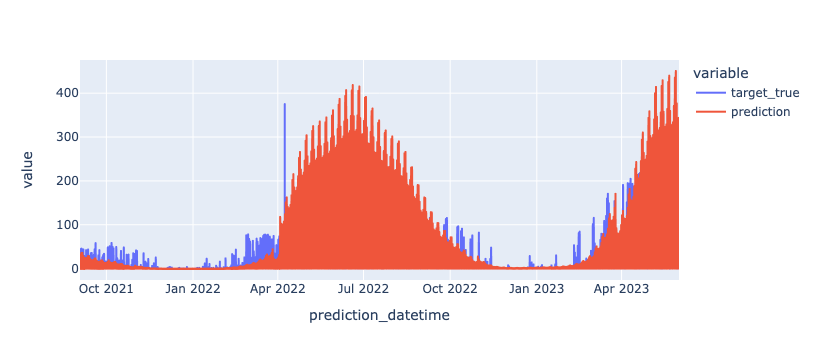

In [25]:
px.line( 
    error_w_zeros.filter(pl.col('prediction_unit_id') == 31), x='prediction_datetime', 
    y=['target_true', 'prediction'] 
)


In [14]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

possible_ids = error_w_zeros['prediction_unit_id'].unique().to_list()

app = Dash(__name__)

app.layout = html.Div([
    dcc.Slider(0, len(possible_ids)+1, 1, value=0, marks=None, id='location_slider'),
    dcc.Graph(id='graph-content')
])

@callback(
    Output('graph-content', 'figure'),
    Input('location_slider', 'value')
)
def update_graph(value):
    unit_id = value
    #if slider_ind != 0:
    #   latitude, longitude = map(float, locations[slider_ind-1].split(','))

    to_plot= error_w_zeros.filter(pl.col('prediction_unit_id') == unit_id)
    
    return px.line(to_plot, x='prediction_datetime', y='error', title=f'Prediction Unit: {unit_id}')

if __name__ == '__main__':
    app.run(debug=True)

#### Interesting features:

- the errors still peak in the summer
- unlike the previous model, there is a balance of positive and negative errors.
- however, within individal prediction units, the there is often a majority of positive or negative errors

These are illustrated below

<Axes: xlabel='prediction_datetime'>

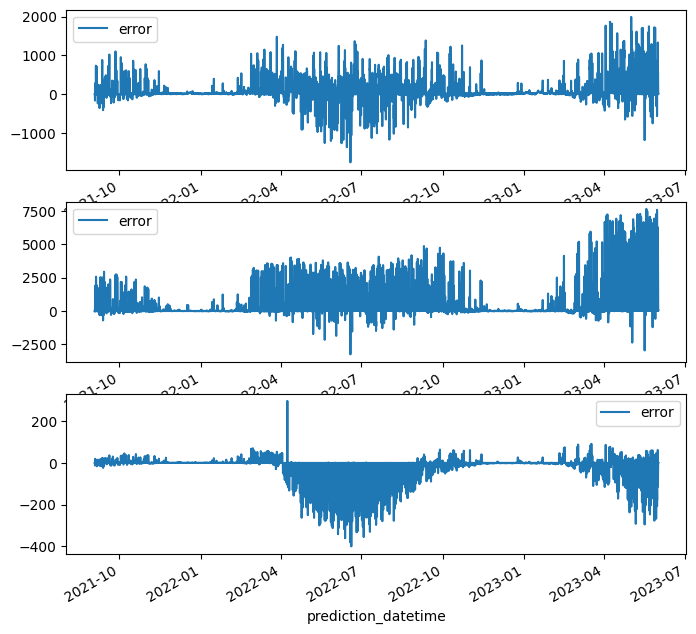

In [24]:
figsize(8,8)
fig, axes = plt.subplots(3,1)

error_w_zeros.filter(pl.col('prediction_unit_id') == 56).to_pandas().plot(x='prediction_datetime',
                                                                          y='error', ax=axes[0]
                                                                          )

error_w_zeros.filter(pl.col('prediction_unit_id') == 2).to_pandas().plot(x='prediction_datetime',
                                                                          y='error', ax=axes[1]
                                                                          )

error_w_zeros.filter(pl.col('prediction_unit_id') == 31).to_pandas().plot(x='prediction_datetime',
                                                                          y='error', ax=axes[2]
                                                                          )
                                                                          


1. The weather effect _is_ multiplicative as well, so the un-fit noisy _should_ peak in July.
2. There is heterogenity between prediction units, which is not captured by these models. Of course, they are all sensitive to different (and quite uncorrelated) local weather
3. In the third case, unit id 31, the negative errors _are_ greater than the total capacity of the unit. Thus, this error looks something like the shared trajectory of the units.


The third error would be decreased by simply normalizing to installed capacity, rather than fitting the capacity effect, although this may cause other problems.

In [59]:
normalized_train = train.join(client[['county', 'product_type', 'is_business', 'date', 'installed_capacity']],
                            left_on=['county', 'product_type', 'is_business', pl.col('prediction_datetime').dt.date()],
                            right_on=['county', 'product_type', 'is_business', 'date'] 
                       ).with_columns( pl.col('target') / pl.col('installed_capacity') )

In [62]:
normalized_model = make_wrapped_model(TransformedTargetRegressor, regressor=LinearRegression(), 
                                      func=np.log1p, inverse_func=np.expm1)

In [64]:
normalized_model.fit(filtered_features, normalized_train)

WrappedModel()

In [70]:
def unnormalize_and_make_error(predictions):
    return predictions.join(normalized_train[['row_id', 'target', 'prediction_datetime', 'installed_capacity']],
                            on='row_id', suffix='_true'
                     ).with_columns(
                          (pl.col('target') * pl.col('installed_capacity')).alias('prediction'),
                          ((pl.col('target_true') - pl.col('target') * pl.col('installed_capacity'))).alias('error') 
                     )

In [75]:
normalized_errors = unnormalize_and_make_error(normalized_model.predict(filtered_features))

print((normalized_errors['error']**2).mean()**0.5)

492.4426001091267


It doesn't improve the training fit, as I should have known because this fit is, of course, an option for linear regression. The fixes will have to be more sophisticated than this.

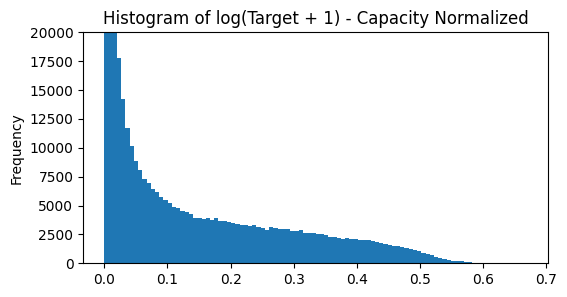

In [119]:
figsize(6,3)
normalized_train.with_columns( np.log1p(pl.col('target')))['target'].to_pandas().plot.hist(bins=100)
plt.ylim([0, 20000])
_=plt.title('Histogram of log(Target + 1) - Capacity Normalized')

This definitely makes the noisy look different: is is not log normal.

(0.0, 50000.0)

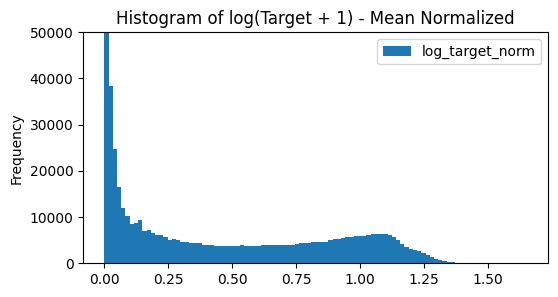

In [122]:
mean_normalized_data = train.join(
        train.group_by(['county', 'is_business', 'product_type']
            ).agg(pl.col('target').mean().alias('mean')),
        on=['county', 'is_business', 'product_type']
    ).with_columns(
        (pl.col('target') / pl.col('mean') ).alias('target_normalized'),
        np.log1p(np.log1p(pl.col('target') / pl.col('mean') )).alias('log_target_norm')
    )

mean_normalized_data.to_pandas()[['log_target_norm']].plot.hist(bins=100)
_=plt.title('Histogram of log(Target + 1) - Mean Normalized')
plt.ylim([0, 50000])

The second peak is surely from changes in the installed capacity

This does go toward explaining why the regression doesn't work well.
1. On a daily (and yearly) level, the standard deviation is proportional to the noisy.
2. The distribution of targets themselves are _not_ log normal.


In [134]:
normalized_train.head()

county,is_business,product_type,target,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,date_when_predicting,installed_capacity
i8,bool,i8,f64,bool,date,i64,i64,i8,date,f64
0,false,1,0.000748,false,2021-09-01,0,0,0,2021-08-30,952.89
0,false,2,0.0,false,2021-09-01,0,2,1,2021-08-30,166.4
0,false,3,0.000403,false,2021-09-01,0,4,2,2021-08-30,7207.88
0,true,0,0.0,false,2021-09-01,0,6,3,2021-08-30,400.0
0,true,1,0.0,false,2021-09-01,0,8,4,2021-08-30,1411.0


In [136]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

possible_ids = error_w_zeros['prediction_unit_id'].unique().to_list()

app = Dash(__name__)

app.layout = html.Div([
    dcc.Slider(0, len(possible_ids)+1, 1, value=0, marks=None, id='location_slider'),
    dcc.Graph(id='graph-content')
])

@callback(
    Output('graph-content', 'figure'),
    Input('location_slider', 'value')
)
def update_graph(value):
    unit_id = value
    #if slider_ind != 0:
    #   latitude, longitude = map(float, locations[slider_ind-1].split(','))

    to_plot= normalized_train.filter(pl.col('prediction_unit_id') == unit_id)
    
    return px.histogram(to_plot, x='target', title=f'Prediction Unit: {unit_id}')

if __name__ == '__main__':
    app.run(debug=True)

In fact, most of the prediction units (except for number 42) look very much like exponential noise, or something along those lines.

I think I'm seeing the issue in my exploratory data analysis. Specifically, it was the assumption (!) of log-normal noise based on the relationship between the mean and standard deviation of prediction units.
More generally, if I am considering one factor (eg. weather) to be noise for the purposes of a model (eg. of time-dependency), I have to characterize the noisy caused by that factor!